In [ ]:
# Installations
!pip install -U trashdetect_engine --quiet
!pip install gdown wandb --quiet
# !pip install efficientnet_pytorch --quiet

     |████████████████████████████████| 1.8 MB 36.6 MB/s 
     |████████████████████████████████| 156 kB 59.6 MB/s 
     |████████████████████████████████| 181 kB 59.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [ ]:
# Download dataset and annotations
!gdown --folder 1Nsik0VXf8tfqllIsJNgUsipaF6Nm18jU
!gdown --id 1W-3pMS0k7DDdSw2HiTCy1hJWgJUkvddw

Retrieving folder list
Processing file 1D-M55oeRuH_tp3FldzELNIlGmkfjBMLW annotations_binary_test.json
Processing file 1sbZADak_vaigZ95l44lNQvQq5YZIhK-C annotations_binary_train.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1D-M55oeRuH_tp3FldzELNIlGmkfjBMLW
To: /content/annotations_with_segmask/annotations_binary_test.json
100% 541k/541k [00:00<00:00, 83.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sbZADak_vaigZ95l44lNQvQq5YZIhK-C
To: /content/annotations_with_segmask/annotations_binary_train.json
100% 2.29M/2.29M [00:00<00:00, 167MB/s]
Download completed
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1W-3pMS0k7DDdSw2HiTCy1hJWgJUkvddw
To

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T
from matplotlib import pyplot as plt
import matplotlib
# matplotlib.use('TkAgg')
# matplotlib.use('GTK3Agg') 

import sys
sys.path.append('../')

In [ ]:
# Download packages
# !pip install efficientnet-pytorch --quiet

In [ ]:
# https://drive.google.com/drive/u/0/folders/1TgoczMbgYgqMcr0ZjKJVkTBAeZ76WNXT
# https://drive.google.com/file/d/1GfgnTOyVmdJxTJ36SC8d9ts_oUWHc418/view?usp=sharing # checkpoint 7
# https://drive.google.com/file/d/1m-j_weoxZ5rZjlKGShTGG0PiFgZ0pi0H/view?usp=sharing # cp5
# https://drive.google.com/file/d/1oY4bY47I315T_O56OU_lfS5CBNphk7nr/view?usp=sharing # cp6
!pip install gdown --quiet
!gdown --id 1oY4bY47I315T_O56OU_lfS5CBNphk7nr # checkpoint6
!gdown --id 1m-j_weoxZ5rZjlKGShTGG0PiFgZ0pi0H # checkpoint5
!gdown --id 1GfgnTOyVmdJxTJ36SC8d9ts_oUWHc418 # checkpoint7

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1oY4bY47I315T_O56OU_lfS5CBNphk7nr
To: /content/checkpoint0006.pth
100% 351M/351M [00:02<00:00, 136MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1m-j_weoxZ5rZjlKGShTGG0PiFgZ0pi0H
To: /content/checkpoint0005.pth
100% 351M/351M [00:04<00:00, 84.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...


In [ ]:
PATH = '/content/checkpoint0006.pth'
NUM_CLASSES = 2
THRESHOLD = 0.6

In [ ]:
CLASSES = ['Litter']

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor()
])

In [ ]:
# from efficientnet_pytorch import EfficientNet
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision
import requests
from io import BytesIO

def load_image_from_url(url):
    print(f'Downloading image from: {url}')
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def load_image_from_local(path):
    img = Image.open(path).convert('RGB')
    return img


# from https://github.com/lukemelas/EfficientNet-PyTorch
def round_filters(filters, global_params):
    """Round number of filters based on depth multiplier."""
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)

def get_instance_segmentation_model(num_classes, model_name="maskrcnn_resnet50_fpn"):
    # load a pre-trained model for classification
    # and return only the features
    if model_name.startswith("efficientnet"):
        backbone = EfficientNet.from_pretrained(
            model_name, num_classes=num_classes, include_top=False
        )
        # number of output channels
        backbone.out_channels = int(round_filters(1280, backbone._global_params))
        model = MaskRCNN(backbone, num_classes)
    else:
        # load an instance segmentation model pre-trained on COCO
        model = torchvision.models.detection.__dict__[model_name](pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if model_name.startswith("mask") or model_name.startswith("efficientnet"):
        # now get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask, hidden_layer, num_classes
        )
    return model

In [ ]:
# Load model and weights
model = get_instance_segmentation_model(NUM_CLASSES)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
_ = model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

In [ ]:
# model.transform

In [ ]:
## Analyze input shape
# URL = 'https://cdn.theatlantic.com/thumbor/u_oEmOaLcNVG1txpg_5i32F4gu8=/0x181:3500x2150/976x549/media/img/mt/2016/07/RTR4TWG7/original.jpg'
# URL = 'https://www.allcountyrecycling.com/blog/admin/uploads/2020/waste-trash-nyc.jpg'
# # URL = 'https://billypenn.com/wp-content/uploads/2022/03/illegaldumping-trash-fairhill-crop-768x432.jpg'
# im = load_image_from_url(URL)
# print('Original size: ', im.size)

In [ ]:
# # Resize(min_size=(800,), max_size=1333, mode='bilinear')
# img = transform(im).unsqueeze(0)
# img_list = model.transform(img)[0]

# print(img_list.image_sizes)

In [ ]:
# (768, 432) --> (749, 1333)
# (976, 549) --> (749, 1332)
# (1200, 800) --> (800, 1200)

In [ ]:
%matplotlib inline 
# Beach
URL = 'https://cdn.theatlantic.com/thumbor/u_oEmOaLcNVG1txpg_5i32F4gu8=/0x181:3500x2150/976x549/media/img/mt/2016/07/RTR4TWG7/original.jpg'
# Street
# URL = 'https://www.inquirer.com/resizer/kRmTeM1lVZVPXwEXeGzT5Q2dLkM=/0x0:4025x2685/760x507/filters:format(webp)/cloudfront-us-east-1.images.arcpublishing.com/pmn/W5XN2PYNKFGXTOMXNI6D6MBWJQ.jpg'

# Forest
THRESHOLD = 0.6
# URL = 'https://media.kjzz.org/s3fs-public/field/image/coconino-national-forest-campsite-trash-20200609.jpg'

# From test set
# URL = 'https://farm66.staticflickr.com/65535/47855505601_a81c3ba8de_z.jpg'

# URL = 'https://farm66.staticflickr.com/65535/48693801613_b8d405ab84_o.png'

# URL = 'https://farm66.staticflickr.com/65535/47855805651_1db7f68985_o.png'
im = load_image_from_url(URL)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

with torch.no_grad():
    outputs = model(img)

plt.figure(figsize=(16, 10))
img = np.array(im)[:, :, 1]
plt.imshow(im)
ax = plt.gca()
keep = outputs[0]["scores"].detach().numpy() > THRESHOLD
prob = outputs[0]["scores"].detach().numpy()[keep].tolist()
labels = outputs[0]["labels"].detach().numpy()[keep].tolist()
masks = outputs[0]["masks"].detach().numpy()[keep]

masking = np.zeros((1,) + img.shape)
for j, i in enumerate(outputs[0]["boxes"].detach().numpy()[keep].tolist()):
    p = prob[j]
    masking += masks[j]
    ax.add_patch(
        plt.Rectangle(
            (i[0], i[1]), i[2] - i[0], i[3] - i[1], fill=False, color="r", linewidth=3
        )
    )
    cl = int(labels[j]) - 1
    text = f"{CLASSES[cl]}: {p:0.2f}"
    ax.text(i[0], i[1], text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))
imagines = np.array(im)
masking[0, ...][np.round(masking[0, ...]) >= 1] = 1
masking[0, ...][np.round(masking[0, ...]) < 1] = 0

alpha = 0.5
color = np.array((1.0, 0.0, 0.0))
for c in range(3):
    imagines[:, :, c] = np.where(masking[0, ...] == 1,
                                imagines[:, :, c] *
                                (1 - alpha) + alpha * color[c] * 255,
                                imagines[:, :, c])
plt.imshow(imagines)
plt.axis("off")


In [ ]:
# %%html
# <iframe src="https://wandb.ai/nma2022-wastedetect/wastedetect/runs/" width="2000" height="1000"></iframe>

In [ ]:
# Installations
!pip install -U trashdetect_engine --quiet
!pip install gdown wandb --quiet
# !pip install efficientnet_pytorch --quiet

In [ ]:
# Download dataset and annotations
!gdown --folder 1Nsik0VXf8tfqllIsJNgUsipaF6Nm18jU
!gdown --id 1W-3pMS0k7DDdSw2HiTCy1hJWgJUkvddw

Retrieving folder list
Processing file 1D-M55oeRuH_tp3FldzELNIlGmkfjBMLW annotations_binary_test.json
Processing file 1sbZADak_vaigZ95l44lNQvQq5YZIhK-C annotations_binary_train.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1D-M55oeRuH_tp3FldzELNIlGmkfjBMLW
To: /content/annotations_with_segmask/annotations_binary_test.json
100% 541k/541k [00:00<00:00, 91.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sbZADak_vaigZ95l44lNQvQq5YZIhK-C
To: /content/annotations_with_segmask/annotations_binary_train.json
100% 2.29M/2.29M [00:00<00:00, 189MB/s]
Download completed
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1W-3pMS0k7DDdSw2HiTCy1hJWgJUkvddw
To

In [ ]:
from trashdetect_engine.coco_eval import COCO
import numpy as np

# /content/annotations_binary_test.json
coco = COCO('/content/annotations_with_segmask/annotations_binary_test.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
def load_data_coco(coco, id: int):
    image_data = coco.loadImgs(id)[0]
    image_anno = coco.loadAnns(coco.getAnnIds(id))
    return image_data, image_anno

In [ ]:
all_image_ids = coco.getImgIds()

In [ ]:
# np.random.choice(all_image_ids, 4)

array([1387,  536, 1278,  947])

In [ ]:
# load_data_coco(coco, 1182)

rand_image_ids:  [ 475 1491  975  122]
Choose sample with id: 475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


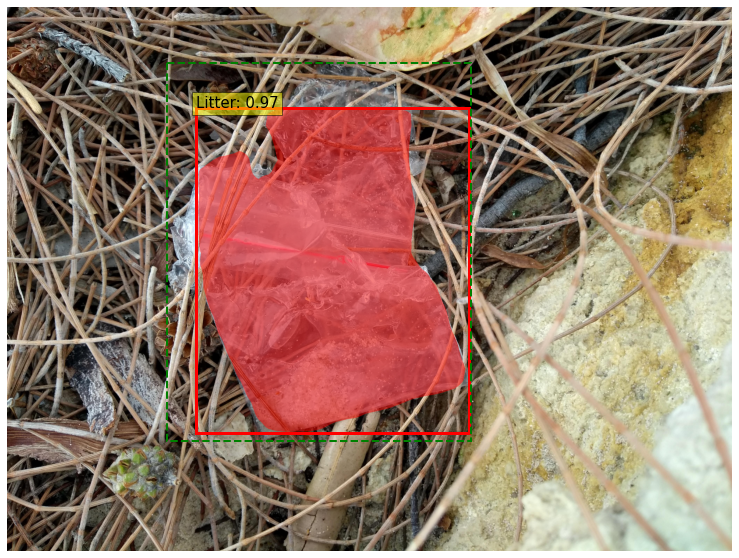

Choose sample with id: 1491


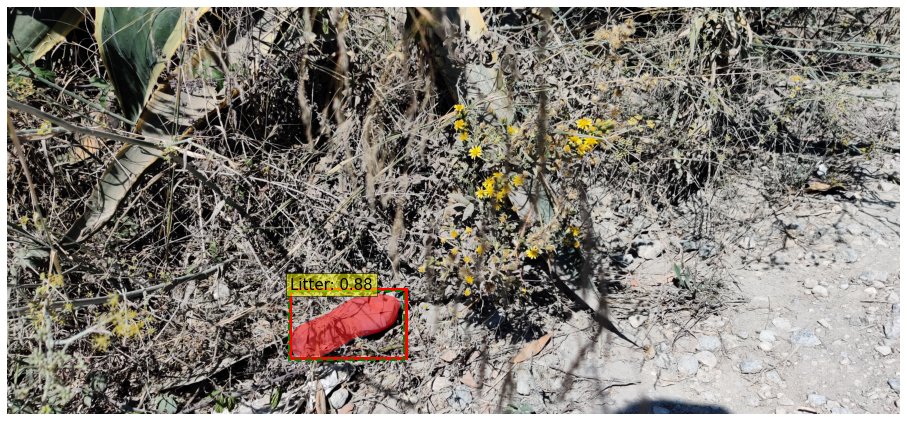

Choose sample with id: 975


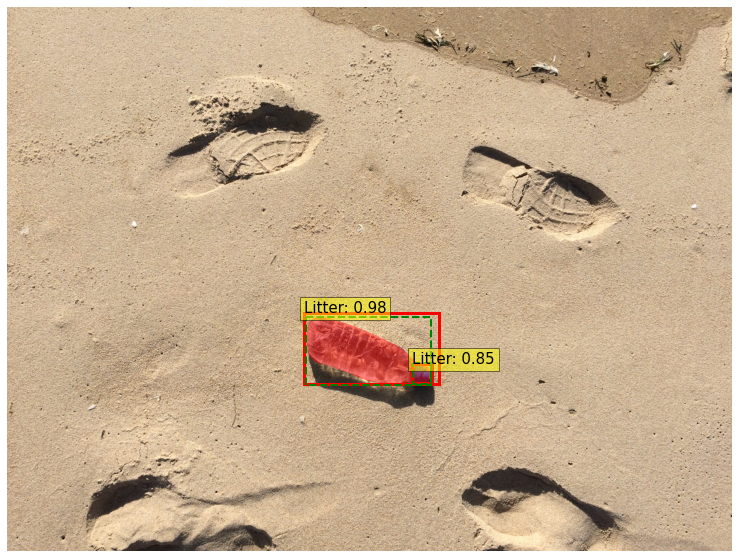

Choose sample with id: 122


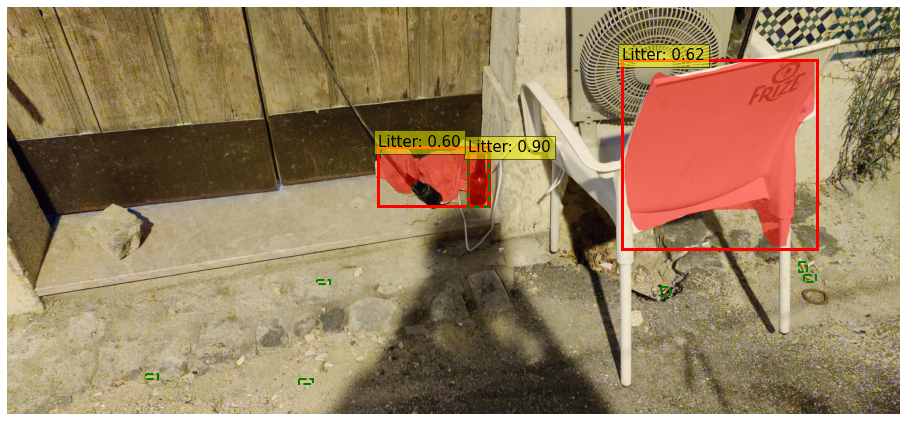

In [ ]:
%matplotlib inline 

rand_image_ids = np.random.choice(all_image_ids, 4)
print("rand_image_ids: ", rand_image_ids)
for rand_image_id in rand_image_ids:
    print(f'Choose sample with id: {rand_image_id}')

    gt_image_data, gt_image_anno = load_data_coco(coco, int(rand_image_id))
    URL = gt_image_data['flickr_url']
    im = load_image_from_url(URL)

    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img)

    plt.figure(figsize=(16, 10))
    img = np.array(im)[:, :, 1]
    plt.imshow(im)
    ax = plt.gca()
    keep = outputs[0]["scores"].detach().numpy() > THRESHOLD
    prob = outputs[0]["scores"].detach().numpy()[keep].tolist()
    labels = outputs[0]["labels"].detach().numpy()[keep].tolist()
    masks = outputs[0]["masks"].detach().numpy()[keep]

    masking = np.zeros((1,) + img.shape)

    # Draw predicted Bboxes
    for j, i in enumerate(outputs[0]["boxes"].detach().numpy()[keep].tolist()):
        p = prob[j]
        masking += masks[j]
        ax.add_patch(
            plt.Rectangle(
                (i[0], i[1]), i[2] - i[0], i[3] - i[1], fill=False, color="r", linewidth=3
            )
        )
        cl = int(labels[j]) - 1
        text = f"{CLASSES[cl]}: {p:0.2f}"
        ax.text(i[0], i[1], text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))

    # Draw Grouth Truth bboxes
    for a in gt_image_anno:
        # x, y, w, h
        bbox = np.array(a['bbox']).astype(np.int)
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3], 
                fill=False, color="green", linewidth=2, 
                linestyle = 'dashed'
            )
        )

    imagines = np.array(im)
    masking[0, ...][np.round(masking[0, ...]) >= 1] = 1
    masking[0, ...][np.round(masking[0, ...]) < 1] = 0

    alpha = 0.5
    color = np.array((1.0, 0.0, 0.0))
    for c in range(3):
        imagines[:, :, c] = np.where(masking[0, ...] == 1,
                                  imagines[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  imagines[:, :, c])
    plt.imshow(imagines)
    plt.axis("off")
    plt.show()


In [ ]:
# --> Reflection/Luminance
# Choose sample with id: 354
# Downloading image from: https://olm-s3.s3.eu-west-1.amazonaws.com/2018/08/28/zGSwGdiiq3gIybROf1HU71pBu6ry2VftipIDjzlO.jpeg

# --> Small + rare-occurence objects
# Choose sample with id: 991
# Downloading image from: https://farm66.staticflickr.com/65535/33978858968_be5ccff215_o.png
# Choose sample with id: 862
# Downloading image from: https://farm66.staticflickr.com/65535/47066375304_40fe0f2270_o.png


# --> Oclusion
# Choose sample with id: 445
# Downloading image from: https://olm-s3.s3.eu-west-1.amazonaws.com/2019/04/16/0k68QlxeXRHkhUOVUAHF8BpZepzsQGUq6rLH42my.jpeg

rand_image_ids:  [354, 862, 445]
Choose sample with id: 354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


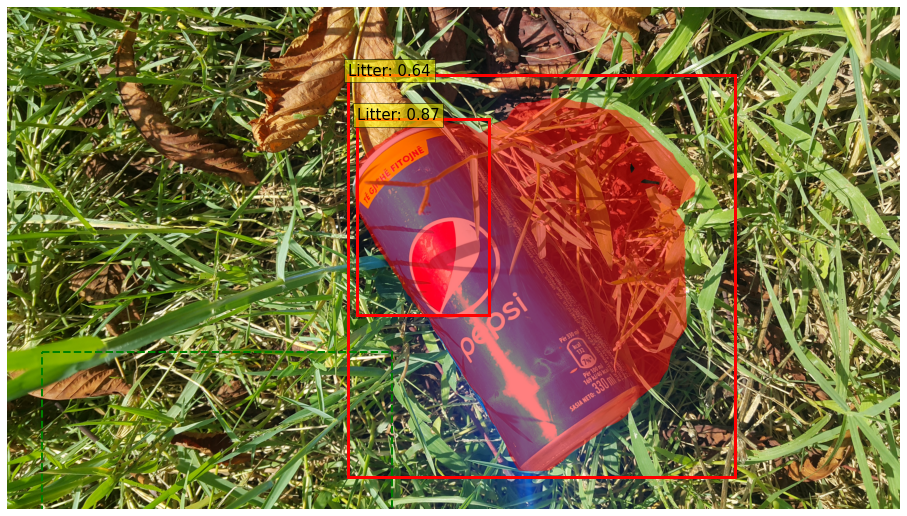

Choose sample with id: 862


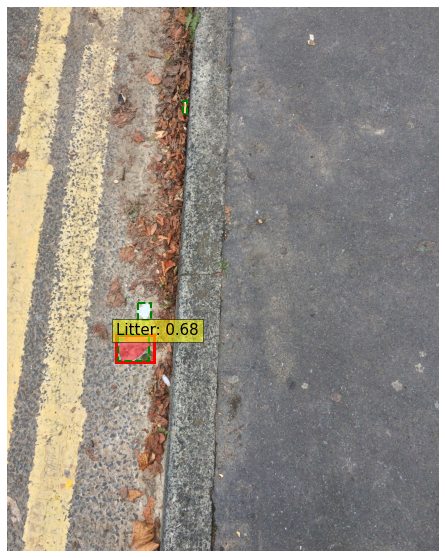

Choose sample with id: 445


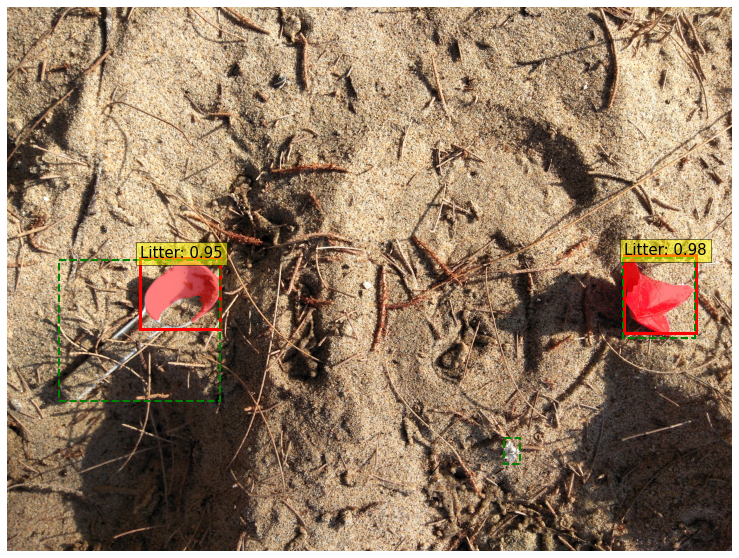

In [ ]:
%matplotlib inline 

rand_image_ids = [354, 862, 445]
print("rand_image_ids: ", rand_image_ids)
for rand_image_id in rand_image_ids:
    print(f'Choose sample with id: {rand_image_id}')

    gt_image_data, gt_image_anno = load_data_coco(coco, int(rand_image_id))
    URL = gt_image_data['flickr_url']
    im = load_image_from_url(URL)

    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img)

    plt.figure(figsize=(16, 10))
    img = np.array(im)[:, :, 1]
    plt.imshow(im)
    ax = plt.gca()
    keep = outputs[0]["scores"].detach().numpy() > THRESHOLD
    prob = outputs[0]["scores"].detach().numpy()[keep].tolist()
    labels = outputs[0]["labels"].detach().numpy()[keep].tolist()
    masks = outputs[0]["masks"].detach().numpy()[keep]

    masking = np.zeros((1,) + img.shape)

    # Draw predicted Bboxes
    for j, i in enumerate(outputs[0]["boxes"].detach().numpy()[keep].tolist()):
        p = prob[j]
        masking += masks[j]
        ax.add_patch(
            plt.Rectangle(
                (i[0], i[1]), i[2] - i[0], i[3] - i[1], fill=False, color="r", linewidth=3
            )
        )
        cl = int(labels[j]) - 1
        text = f"{CLASSES[cl]}: {p:0.2f}"
        ax.text(i[0], i[1], text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))

    # Draw Grouth Truth bboxes
    for a in gt_image_anno:
        # x, y, w, h
        bbox = np.array(a['bbox']).astype(np.int)
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3], 
                fill=False, color="green", linewidth=2, 
                linestyle = 'dashed'
            )
        )

    imagines = np.array(im)
    masking[0, ...][np.round(masking[0, ...]) >= 1] = 1
    masking[0, ...][np.round(masking[0, ...]) < 1] = 0

    alpha = 0.5
    color = np.array((1.0, 0.0, 0.0))
    for c in range(3):
        imagines[:, :, c] = np.where(masking[0, ...] == 1,
                                  imagines[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  imagines[:, :, c])
    plt.imshow(imagines)
    plt.axis("off")
    plt.show()
